# Introduction to [`dipy`](http://dipy.org)

# Why `dipy`? 

- Fully free and open source
- Implemented in Python. Easy to understand, and easy to use.
- Implementations of many state-of-the art algorithms
- High performance. Many algorithms implemented in [`cython`](http://cython.org/)


We'll start by installing dipy from the source code(!)

### Defining a measurement: `GradientTable`

A diffusion MRI measurement is usually defined through a set of gradient directions and the gradient amplitudes associated with these gradient directions. We usually also include the measurements in which no diffusion weighting was applied ('b0' measurements). 

There is a simple `GradientTable` object implemented in the `dipy.core.gradients` module

In [1]:
import dipy.core.gradients as grad
import numpy as np

In [2]:
gtab = grad.gradient_table([0, 1000., 1000., 1000.], np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]))

A `b0s_mask` can be used to separate diffusion weighted from non diffusion weighted measurements:

In [3]:
gtab.bvecs[~gtab.b0s_mask]

array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.]])

Let's consider some actual diffusion data. The `dipy.data` module can be used to read data from various sources. For example, we have some diffusion data that we collected back in the day at Stanford:

In [4]:
from dipy.data import read_stanford_hardi
img, gtab = read_stanford_hardi()

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/stanford_hardi 


In [5]:
print(type(img), type(gtab))

(<class 'nibabel.nifti1.Nifti1Image'>, <class 'dipy.core.gradients.GradientTable'>)


#### Exercise: 
1. Calculate the mean b0 image from the stanford HARDI data. How many b=0 images are there? What b values were used?

2. Calculate the relative diffusion weighted signal ($S/S_0$)

3. Display these in side-by-side plots

### Reconstruction with the `dipy.reconst` module

The `reconst` module contains implementations of the following models: 

- Tensor (Basser et al., 1994)
- Constrained Spherical Deconvolution (Tournier et al. 2007)
- Diffusion Kurtosis (Jensen et al. 2005)
- DSI (Wedeen et al. 2008)
- DSI with deconvolution (Canales-Rodriguez et al. 2010)
- Generalized Q Imaging (Yeh et al. 2010)
- MAPMRI (Ozarsalan et al. 2013)
- SHORE (Ozarsalan et al. 2008)
- CSA (Aganj et al. 2009)
- Q ball (Descoteaux et al. 2007)
- OPDT (Tristan-Vega et al. 2010)
- Sparse Fascicle Model (Rokem et al. 2015)

The different algorithms implemented in the `reconst` module all share a similar conceptual structure: 

- `ReconstModel` objects (e.g, `TensorModel`) carry the parameters that are required in order to fit a model. For example, the directions and intensities of the gradients that were applied in the experiment. The all have a `fit` method, which takes in data, and emits a `ReconstFit` object. This is where a lot of the heavy lifting will take place.
- `ReconstFit` objects carry the model that was used to generate them. They also carry around the parameters that were estimated during fitting of the data. They have methods to calculate derived statistics, such as FA and MD (for the tensor), which can differ from module to module. The also all have an `odf` , and most of them (but not all) have `predict` methods, which allow you to predict another data-set based on the a gradient table.


### Reconstruction of the diffusion signal with the Tensor model

The diffusion tensor model is a model that describes the diffusion within a
voxel. First proposed by Basser and colleagues [Basser1994]_, it has been very
influential in demonstrating the utility of diffusion MRI in characterizing the
micro-structure of white matter tissue and of the biophysical properties of
tissue, inferred from local diffusion properties and it is still very commonly
used.

The diffusion tensor models the diffusion signal as:


$\frac{S(\mathbf{g}, b)}{S_0} = e^{-b\mathbf{g}^T \mathbf{D} \mathbf{g}}$

Where $\mathbf{g}$ is a unit vector in 3 space indicating the direction of
measurement and b are the parameters of measurement, such as the strength and
duration of diffusion-weighting gradient. $S(\mathbf{g}, b)$ is the
diffusion-weighted signal measured and $S_0$ is the signal conducted in a
measurement with no diffusion weighting. $\mathbf{D}$ is a positive-definite quadratic
form, which contains six free parameters to be fit. These six parameters are:

$\mathbf{D} = \begin{pmatrix} D_{xx} & D_{xy} & D_{xz} \\
                       D_{yx} & D_{yy} & D_{yz} \\
                       D_{zx} & D_{zy} & D_{zz} \\ \end{pmatrix}$

This matrix is a variance/covariance matrix of the diffusivity along the three
spatial dimensions. Note that we can assume that diffusivity has antipodal
symmetry, so elements across the diagonal are equal. For example:
$D_{xy} = D_{yx}$. This is why there are only 6 free parameters to estimate
here.

In the following example we show how to reconstruct your diffusion datasets
using a single tensor model.

In [6]:
import dipy.reconst.dti as dti

In [7]:
dti_model = dti.TensorModel(gtab)

In [35]:
data = img.get_data()
print(data.shape)
dti_fit = dti_model.fit(data)

(81, 106, 76, 160)


The fit method creates a TensorFit object which contains the fitting parameters
and other attributes of the model. For example we can generate fractional
anisotropy (FA) from the eigen-values of the tensor. FA is used to characterize
the degree to which the distribution of diffusion in a voxel is
directional. That is, whether there is relatively unrestricted diffusion in one
particular direction.

Mathematically, FA is defined as the normalized variance of the eigenvalues of
the tensor:

$FA = \sqrt{\frac{1}{2}\frac{(\lambda_1-\lambda_2)^2+(\lambda_1-
                    \lambda_3)^2+(\lambda_2-\lambda_3)^2}{\lambda_1^2+
                   \lambda_2^2+\lambda_3^2}}$

Note that FA should be interpreted carefully. It may be an indication of the
density of packing of fibers in a voxel, and the amount of myelin wrapping these
axons, but it is not always a measure of "tissue integrity". For example, FA
may decrease in locations in which there is fanning of white matter fibers, or
where more than one population of white matter fibers crosses.

Other tensor statistics can be calculated from the `tenfit` object. For example,
a commonly calculated statistic is the mean diffusivity (MD). This is simply the
mean of the  eigenvalues of the tensor. Since FA is a normalized
measure of variance and MD is the mean, they are often used as complimentary
measures. In `dipy`, there are two equivalent ways to calculate the mean
diffusivity. One is by calling the `mean_diffusivity` module function on the
eigen-values of the TensorFit class instance:

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline 

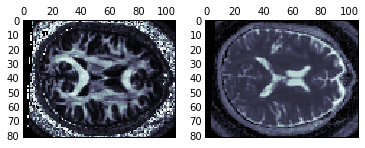

In [19]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(dti_fit.fa[:,:, dti_fit.fa.shape[-1]//2], cmap='bone')
ax[1].matshow(dti_fit.md[:,:, dti_fit.md.shape[-1]//2], cmap='bone')

Optionally, we can do 'skull-stripping', based on the diffusion data, and derive a mask, such that the analysis is conducted only on the interesting parts of the volume

In [23]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, median_radius=3, numpass=1, autocrop=False,
                             vol_idx=range(10, 50), dilate=2)

In [24]:
dti_fit = dti_model.fit(data, mask=mask)

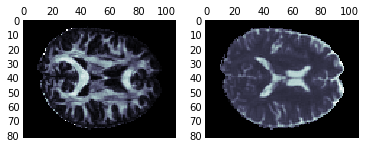

In [25]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(dti_fit.fa[:,:, dti_fit.fa.shape[-1]//2], cmap='bone')
ax[1].matshow(dti_fit.md[:,:, dti_fit.md.shape[-1]//2], cmap='bone')

In the background of the image the fitting will not be accurate there is no
signal and possibly we will find FA values with nans (not a number). We can
remove these using the `np.isnan` function. We can also clip the values to 
be between 0 and 1:

In [29]:
dti_fit.fa[np.isnan(dti_fit.fa)] = 0
dti_fit.fa = np.clip(dti_fit.fa, 0, 1)

### Tensor visualizations
There are several different ways to visualize tensors. One popular way is an RGB map based on the PDD of the tensor and the FA:

In [43]:
from dipy.reconst.dti import color_fa
RGB = color_fa(dti_fit.fa, dti_fit.evecs)

In [44]:
print(RGB.shape)

(81, 106, 76, 3)


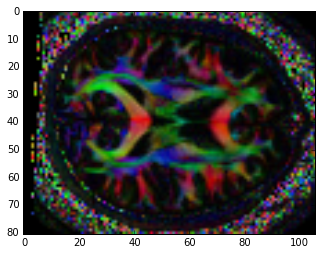

In [45]:
fig, ax = plt.subplots(1)
ax.imshow(RGB[:,:, RGB.shape[-2]//2, :])

Next, we'll use `dipy.viz.fvtk` for 3D visualizations

In [46]:
from dipy.viz import fvtk

We'll zoom in on a single slice of the image, in a quadrant of the brain

In [48]:
evals = dti_fit.evals[13:43, 44:74, 28:29]
evecs = dti_fit.evecs[13:43, 44:74, 28:29]
cfa = RGB[13:43, 44:74, 28:29]
cfa /= cfa.max()

Using a sphere with 724 points, we can get smoother-looking visuals

In [49]:
from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

In [50]:
ren = fvtk.ren()
fvtk.add(ren, fvtk.tensor(evals, evecs, cfa, sphere))

We can save it out to a file:

In [51]:
fvtk.record(ren, n_frames=1, out_path='tensor_ellipsoids.png', size=(600, 600))

Or view it interactively (note that this takes focus from the notebook session, until the VTK window is closed!)

In [53]:
fvtk.show(ren)

Finally, we can visualize the tensor orientation distribution functions
for the same area as we did with the ellipsoids.

We will continue to work with the ODFs in the next notebook (tracking)

In [55]:
tensor_odfs = dti_model.fit(data[20:50, 55:85, 38:39]).odf(sphere)

In [56]:
fvtk.clear(ren)
fvtk.add(ren, fvtk.sphere_funcs(tensor_odfs, sphere, colormap=None))
fvtk.record(ren, n_frames=1, out_path='tensor_odfs.png', size=(600, 600))
fvtk.show(ren)